# Node2Vec
- グラフデータを特定のタスクに依存しない汎用的な特徴ベクトルに埋め込む手法
- Coraネットワークを利用してネットワークを生成する


GPU PyTorchの動作確認

In [1]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Sep 26 2025, 17:05:50) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [2]:
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import RandomLinkSplit

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None

# エッジをトレーニング、検証、テストセットに分割
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

# データセットの情報を表示
print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")
print(f"TEST       node num: {test_data.x.size(0)}, edge num: {test_data.edge_index.size(1)}, node feature num: {test_data.num_node_features}")

TRAIN      node num: 2708, edge num: 8448, node feature num: 1433
VALIDATION node num: 2708, edge num: 8448, node feature num: 1433
TEST       node num: 2708, edge num: 9502, node feature num: 1433


### データを可視化

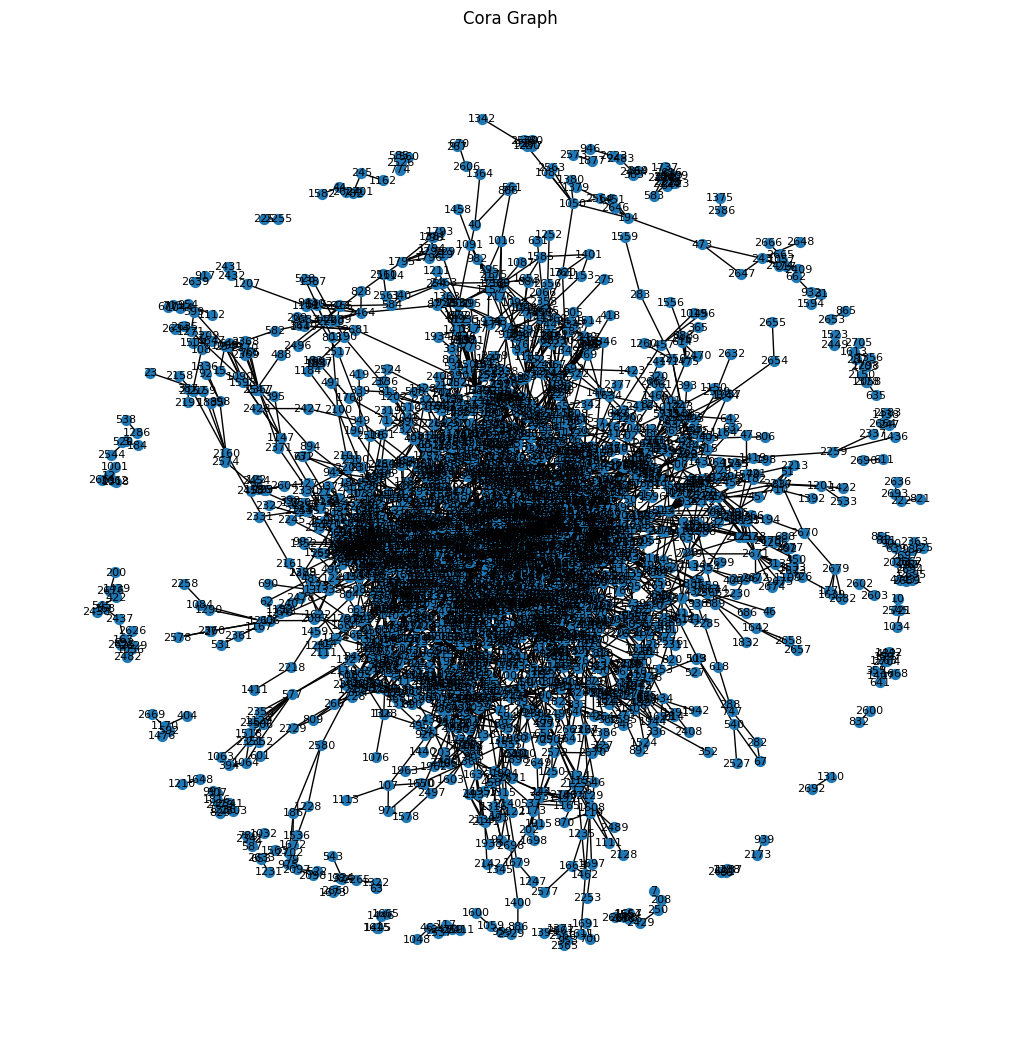

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(train_data.edge_index.t().tolist())

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## Node2Vecを利用したエンベディング
Node2Vecは文における次の単語を予測できるように学習させるスキップグラムを応用した手法である。ネットワークのサンプリングはBFSとDFSを考慮している。

### Node2Vecモデルの定義
Args:
- edge_index: グラフのエッジインデックス
- embedding_dim: 埋め込み次元数
- walk_length: ランダムウォークの長さ
- context_size: コンテキストウィンドウサイズ
- walks_per_node: ノードあたりのウォーク数
- num_negative_samples: ネガティブサンプル数
- p: return parameter (戻る確率の制御)
- q: in-out parameter (探索の幅と深さの制御)
- sparse: スパース勾配を使用するかどうか

In [4]:
from torch_geometric.nn import Node2Vec
import torch

# データの転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# モデルのインスタンス化
print("Node2Vecモデルを初期化中...")
model = Node2Vec(
    train_data.edge_index, 
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=0.5,
    q=1.0,
    sparse=True
).to(device)
print(f"モデルが作成されました。デバイス: {device}")
print(f"ノード数: {model.num_nodes}")

Node2Vecモデルを初期化中...
モデルが作成されました。デバイス: cuda
ノード数: 2708


### モデルの学習

In [5]:
# Node2Vecモデルの訓練
print("Node2Vecモデルの訓練を開始...")

num_epochs = 100
losses = []
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
pos_rw, neg_rw = next(iter(loader))

model.train()
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss = total_loss / len(loader)
    losses.append(total_loss)

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss:.4f}')

print("訓練完了!")

Node2Vecモデルの訓練を開始...
Epoch 20, Loss: 0.9695
Epoch 40, Loss: 0.8090
Epoch 60, Loss: 0.7879
Epoch 80, Loss: 0.7809
Epoch 100, Loss: 0.7796
訓練完了!


埋め込みベクトルの形状: torch.Size([2708, 128])

リンク予測の評価中...


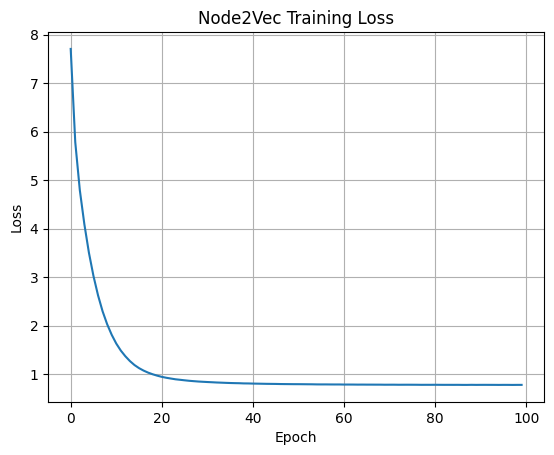

In [6]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_curve, auc

# 学習済み埋め込みの取得
model.eval()
with torch.no_grad():
    embeddings = model()
print(f"埋め込みベクトルの形状: {embeddings.shape}")

# リンク予測の評価
print("\nリンク予測の評価中...")

# 検証データでの評価
pos_edge_index = val_data.edge_index
neg_edge_index = negative_sampling(
    edge_index=train_data.edge_index,
    num_nodes=train_data.num_nodes,
    num_neg_samples=pos_edge_index.size(1)
)

# リンク予測の評価
model.eval()
with torch.no_grad():
    embeddings = model()
    # 正のエッジのスコア計算
    pos_scores = []
    for i in range(0, pos_edge_index.size(1), 1000):  # バッチ処理
        batch_edges = pos_edge_index[:, i:i+1000]
        scores = (embeddings[batch_edges[0]] * embeddings[batch_edges[1]]).sum(dim=1)
        pos_scores.append(torch.sigmoid(scores))
    pos_scores = torch.cat(pos_scores)
        
    # 負のエッジのスコア計算
    neg_scores = []
    for i in range(0, neg_edge_index.size(1), 1000):  # バッチ処理
        batch_edges = neg_edge_index[:, i:i+1000]
        scores = (embeddings[batch_edges[0]] * embeddings[batch_edges[1]]).sum(dim=1)
        neg_scores.append(torch.sigmoid(scores))
    neg_scores = torch.cat(neg_scores)
        
    # AUCスコアの計算
    y_true = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])
    y_score = torch.cat([pos_scores, neg_scores])
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_score.cpu())
    roc_auc = auc(fpr, tpr)

# 損失の可視化
plt.plot(losses)
plt.title('Node2Vec Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

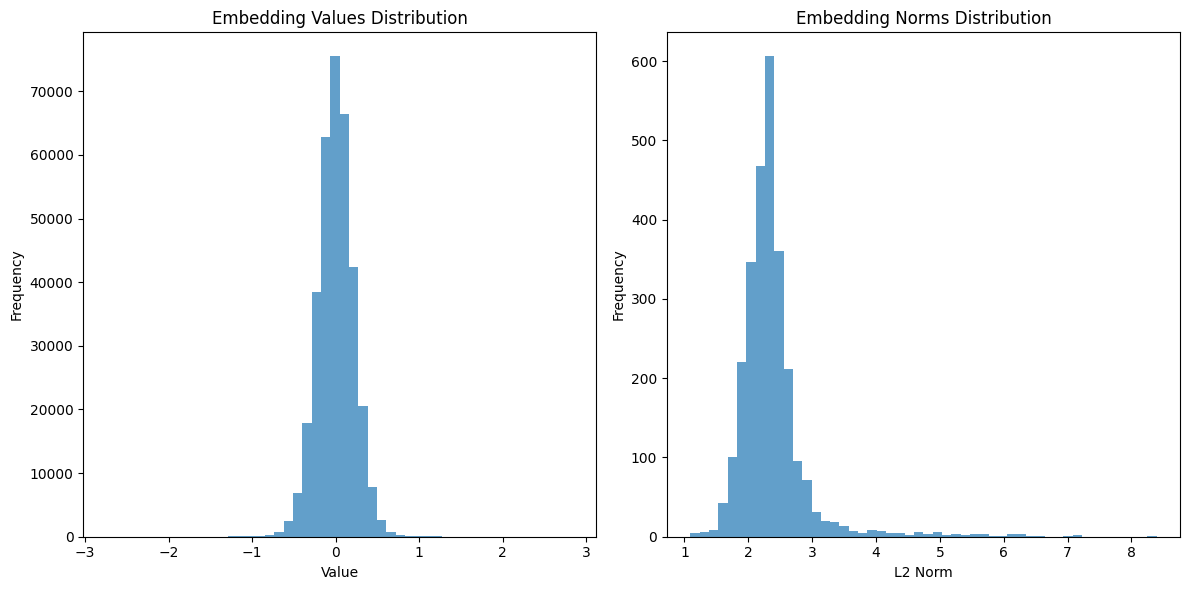

In [7]:
# 埋め込みベクトルの分布を可視化
plt.figure(figsize=(12, 6))

# 埋め込み値のヒストグラム
plt.subplot(1, 2, 1)
plt.hist(embeddings.detach().cpu().numpy().flatten(), bins=50, alpha=0.7)
plt.title('Embedding Values Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 埋め込みベクトルのノルムのヒストグラム
plt.subplot(1, 2, 2)
norms = torch.norm(embeddings, dim=1).detach().cpu().numpy()
plt.hist(norms, bins=50, alpha=0.7)
plt.title('Embedding Norms Distribution')
plt.xlabel('L2 Norm')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

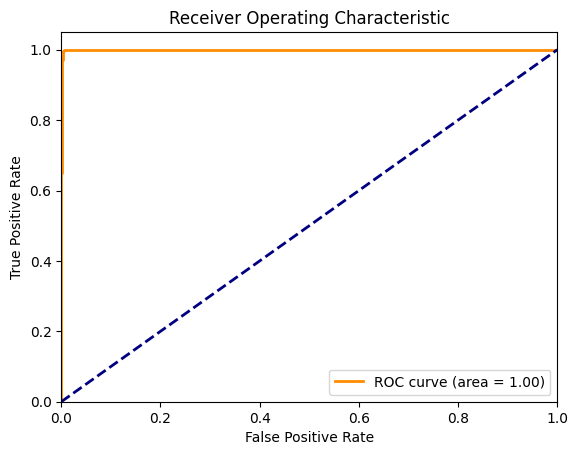

In [8]:
# ROC曲線のプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 埋め込みベクトルの可視化

t-SNEを使用して高次元の埋め込みベクトルを2次元に縮約し、可視化します。

t-SNEによる次元削減を実行中...


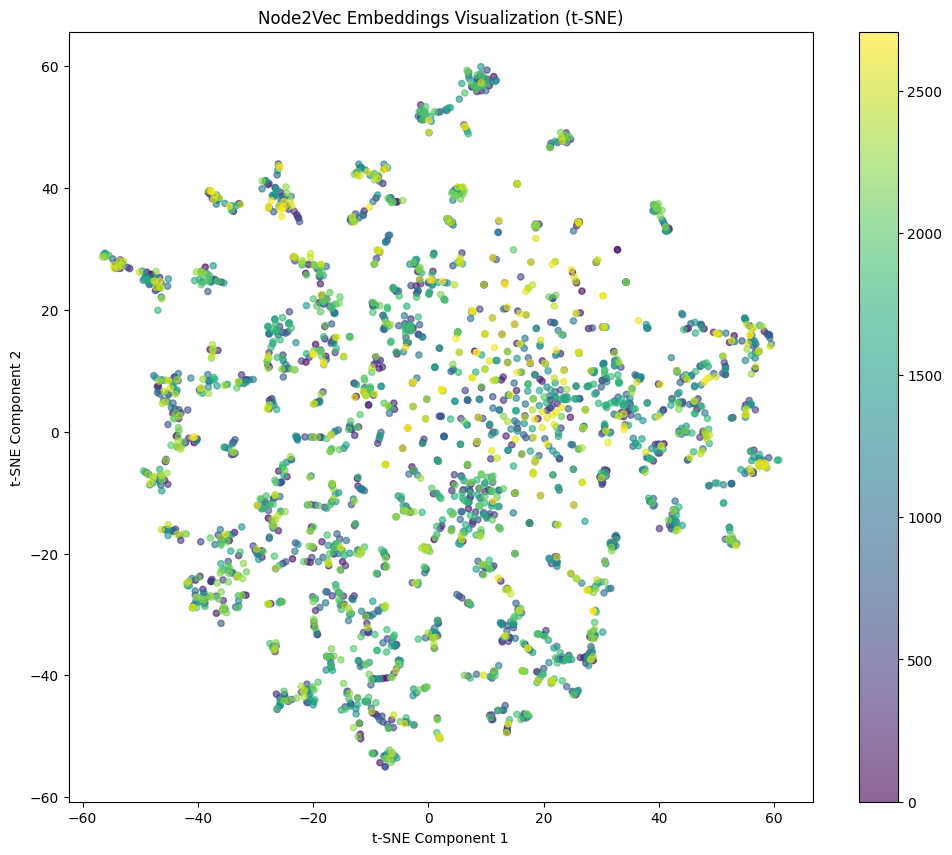


ノード間のコサイン類似度（上位10ペア）:
1. ノード 1489 - ノード 1489: 1.0000
2. ノード 1291 - ノード 1291: 1.0000
3. ノード 901 - ノード 901: 1.0000
4. ノード 980 - ノード 980: 1.0000
5. ノード 360 - ノード 360: 1.0000
6. ノード 212 - ノード 212: 1.0000
7. ノード 440 - ノード 440: 1.0000
8. ノード 894 - ノード 894: 1.0000
9. ノード 1495 - ノード 1495: 1.0000
10. ノード 1549 - ノード 1549: 1.0000

埋め込みベクトルの統計:
平均ノルム: 2.3726
標準偏差: 0.5786
最大コサイン類似度: 1.0000
最小コサイン類似度: -0.4396


In [9]:
from sklearn.manifold import TSNE
from torch.nn import functional as F

# t-SNEを使用して埋め込みベクトルを2次元に縮約
print("t-SNEによる次元削減を実行中...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())

# 2次元埋め込みの可視化
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=range(len(embeddings_2d)), cmap='viridis', 
                     alpha=0.6, s=20)
plt.colorbar(scatter)
plt.title('Node2Vec Embeddings Visualization (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# ノード間の類似度分析（上位10ノードのペア）
print("\nノード間のコサイン類似度（上位10ペア）:")
similarity_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)

# 上位の類似ペアを取得（対角成分を除く）
similarity_matrix.cpu().fill_diagonal_(-1)  # 自分自身との類似度を除外
top_similarities = similarity_matrix.flatten().topk(10)

for i, (sim_value, idx) in enumerate(zip(top_similarities.values, top_similarities.indices)):
    node1 = idx // similarity_matrix.size(0)
    node2 = idx % similarity_matrix.size(0)
    print(f"{i+1}. ノード {node1.item()} - ノード {node2.item()}: {sim_value.item():.4f}")

print(f"\n埋め込みベクトルの統計:")
print(f"平均ノルム: {torch.norm(embeddings, dim=1).mean().item():.4f}")
print(f"標準偏差: {torch.norm(embeddings, dim=1).std().item():.4f}")
print(f"最大コサイン類似度: {similarity_matrix.max().item():.4f}")
print(f"最小コサイン類似度: {similarity_matrix.min().item():.4f}")